In [2]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import colorsys
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

stimrespdecodingfilename = 'D:\\stimdecoding_resp.csv'
stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [ ]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

In [3]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']

tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','AE_235','AE_236','TH_237']#,'TH_217']

unuseddualanimals = ['BS_78']

#animalnames = np.concatenate([dualanimalnames])#,opsinanimalnames,tuninganimalnames,unuseddualanimals])
animalnames = np.concatenate([tuninganimalnames])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
# #Dual Recording Animals
# #animals['BS_33'].reversal = 20
# animals['BS_67'].reversal = 7
# # animals['BS_73'].reversal = np.nan
# # animals['BS_78'].reversal = np.nan
# animals['BS_108'].reversal = 7
# #animals['BS_113'].reversal = 13
# animals['BS_40'].reversal = 18
# animals['BS_41'].reversal = 6
# animals['BS_42'].reversal = 7
# animals['BS_49'].reversal = 13
# animals['BS_50'].reversal = 12
# animals['BS_51'].reversal = 8
# #animals['BS_52'].reversal = 15
# animals['BS_56'].reversal = 8
# animals['BS_59'].reversal = 7
# #animals['BS_61'].reversal = 9    ###
# animals['BS_70'].reversal = 8
# animals['BS_72'].reversal = 6
# #animals['BS_83'].reversal = 20
# #animals['BS_85'].reversal = 10
# animals['BS_87'].reversal = 6
# #animals['DS_16'].reversal = 11
# #animals['BS_95'].reversal = 8
# #animals['DS_15'].reversal = 12
# #animals['DS_19'].reversal = 12

# #Opsin Animals
# animals['BS_86'].reversal = 14
# animals['BS_92'].reversal = 9
# animals['BS_100'].reversal = 11
# animals['BS_103'].reversal = 8
# animals['BS_111'].reversal = 8
# animals['BS_119'].reversal = 10
# animals['BS_123'].reversal = 9
# animals['BS_128'].reversal = 6
# animals['BS_131'].reversal = 14
# animals['BS_139'].reversal = 10
# animals['BS_163'].reversal = 13
# animals['BS_165'].reversal = np.Inf
# animals['BS_174'].reversal = 14
# animals['BS_179'].reversal = 16
# animals['BS_191'].reversal = 10
# animals['BS_192'].reversal = 7

#Tuning Animals
animals['BS_173'].reversal = 15
animals['BS_175'].reversal = 11
animals['BS_187'].reversal = 8
animals['BS_188'].reversal = 8
animals['BS_213'].reversal = 8
animals['BS_214'].reversal = np.Inf
#animals['TH_217'].reversal = 20
animals['AE_235'].reversal = np.Inf ### Pending
animals['AE_236'].reversal = np.Inf ### Pending
animals['TH_237'].reversal = np.Inf ### Pending

print([a for a in animals])

['BS_173', 'BS_175', 'BS_187', 'BS_188', 'BS_213', 'BS_214', 'AE_235', 'AE_236', 'TH_237']


In [4]:
def getExpertDays(animalBehaviors,animal):
    days = np.sort([k for k in animalBehaviors[animal].sessions])
    num_days = len(days)
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    #############################################################
    #                   Find prereversal expert                 #
    #############################################################
    
    pre_expert_days = []
    
    if np.isfinite(reversal):
        if reversal == int(reversal):
            days_to_check = np.sort(list(range(1,reversal)))[::-1]
        else:
            days_to_check = np.sort(list(range(1,int(np.floor(reversal))+1)))[::-1]
    else:
        days_to_check = np.sort(list(range(1,num_days+1)))[::-1]
        reversal = np.max(days_to_check)+1
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        
        exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
        if exceptionTrials is None:
            valid_trials_mask = ilep.getActiveTrials(outcomes)
        else:
            valid_trials_mask = exceptionTrials
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            if np.isfinite(reversal):
                [pre_expert_days.append(d) for d in list(range(day,reversal+1))]
            else:
                [pre_expert_days.append(d) for d in list(range(day,np.max(days_to_check)+1))]
        elif day != days_to_check[0]:
            pass#break
    #if len(pre_expert_days)>0:
    #    pre_expert_days = np.concatenate((pre_expert_days))
    pre_expert_days = np.sort(np.unique(pre_expert_days))[::-1]
           
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_40':
        pre_expert_days = np.array([17,16])
    if animal == 'BS_42':
        pre_expert_days = np.array([6,5])
    if animal == 'BS_50':
        pre_expert_days = np.array([11,10])
        
    #############################################################
    #                  Find postreversal expert                 #
    #############################################################
    
    if not np.isfinite(reversal):
        return pre_expert_days,[]
    
    post_expert_days = []
    days_to_check = np.sort(list(range(reversal+1,num_days+1)))[::-1]
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        valid_trials_mask = ilep.getActiveTrials(outcomes)
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            #post_expert_days.append(day)
            #if day == days_to_check[1]:
            [post_expert_days.append(d) for d in list(range(day,num_days+1))]
                #post_expert_days.append(day+1)
        elif day != days_to_check[0]:
            pass#break
    #if len(post_expert_days)>0:
    #    post_expert_days = np.concatenate((post_expert_days))
    post_expert_days = np.sort(np.unique(post_expert_days))[::-1]
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_49':
        post_expert_days = np.array([20,19,18])
        
    return pre_expert_days,post_expert_days

In [5]:
def getPCDPfromBehavior(animalBehaviors,animal,days,expert):
    cond = np.full_like(days,np.nan,dtype='float')
    cond_pc = np.full_like(days,np.nan,dtype='float')
    if not animal in animalBehaviors:
        return cond,cond_pc
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
        
    #We will remove the duplicate reversal day because we will calculate both
    #pre and post reversal when we get there at once
    days = np.unique(days)
    
    for idx,day in enumerate(days):
        if not day in animalBehaviors[animal].sessions:
            continue
            
        #We still want to put the post-reversal days in the right place, so we have to account
        #for the double reversal day
        if hasattr(animalBehaviors[animal],'reversal') and day > animalBehaviors[animal].reversal:
            idx+=1
            
        ########## Pre/Postreversal ##########
        if day != reversal:
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            #We will trim for active trials only on expert days
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                pass#print(f"Trimming via exception trials")
                valid_trials_mask = exceptionTrials
                outcomes = outcomes[valid_trials_mask]
            elif day in expert:
                valid_trials_mask = ilep.getActiveTrials(outcomes)
                outcomes = outcomes[valid_trials_mask]

            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))

            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            #print(dp)
            if not exceptionTrials is None:
                pass#print(f"PC is {pc} dp is {dp}")

            cond[idx] = dp
            cond_pc[idx] = pc
            
        ########## Switch ##########
        if day == reversal:
            trials_per_session = animalBehaviors[animal].sessions[day].trials_per_session
            pre_reversal_trials = range(int(trials_per_session[0]))
            post_reversal_trials = range(int(trials_per_session[0]),int(np.sum(trials_per_session)))
            
            #Prereversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[pre_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx] = dp
            cond_pc[idx] = pc

            #Postreversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[post_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx+1] = dp
            cond_pc[idx+1] = pc
            
    return cond,cond_pc

BS_173
BS_175


C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_187
BS_188


C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_213
BS_214
AE_235
AE_236
TH_237


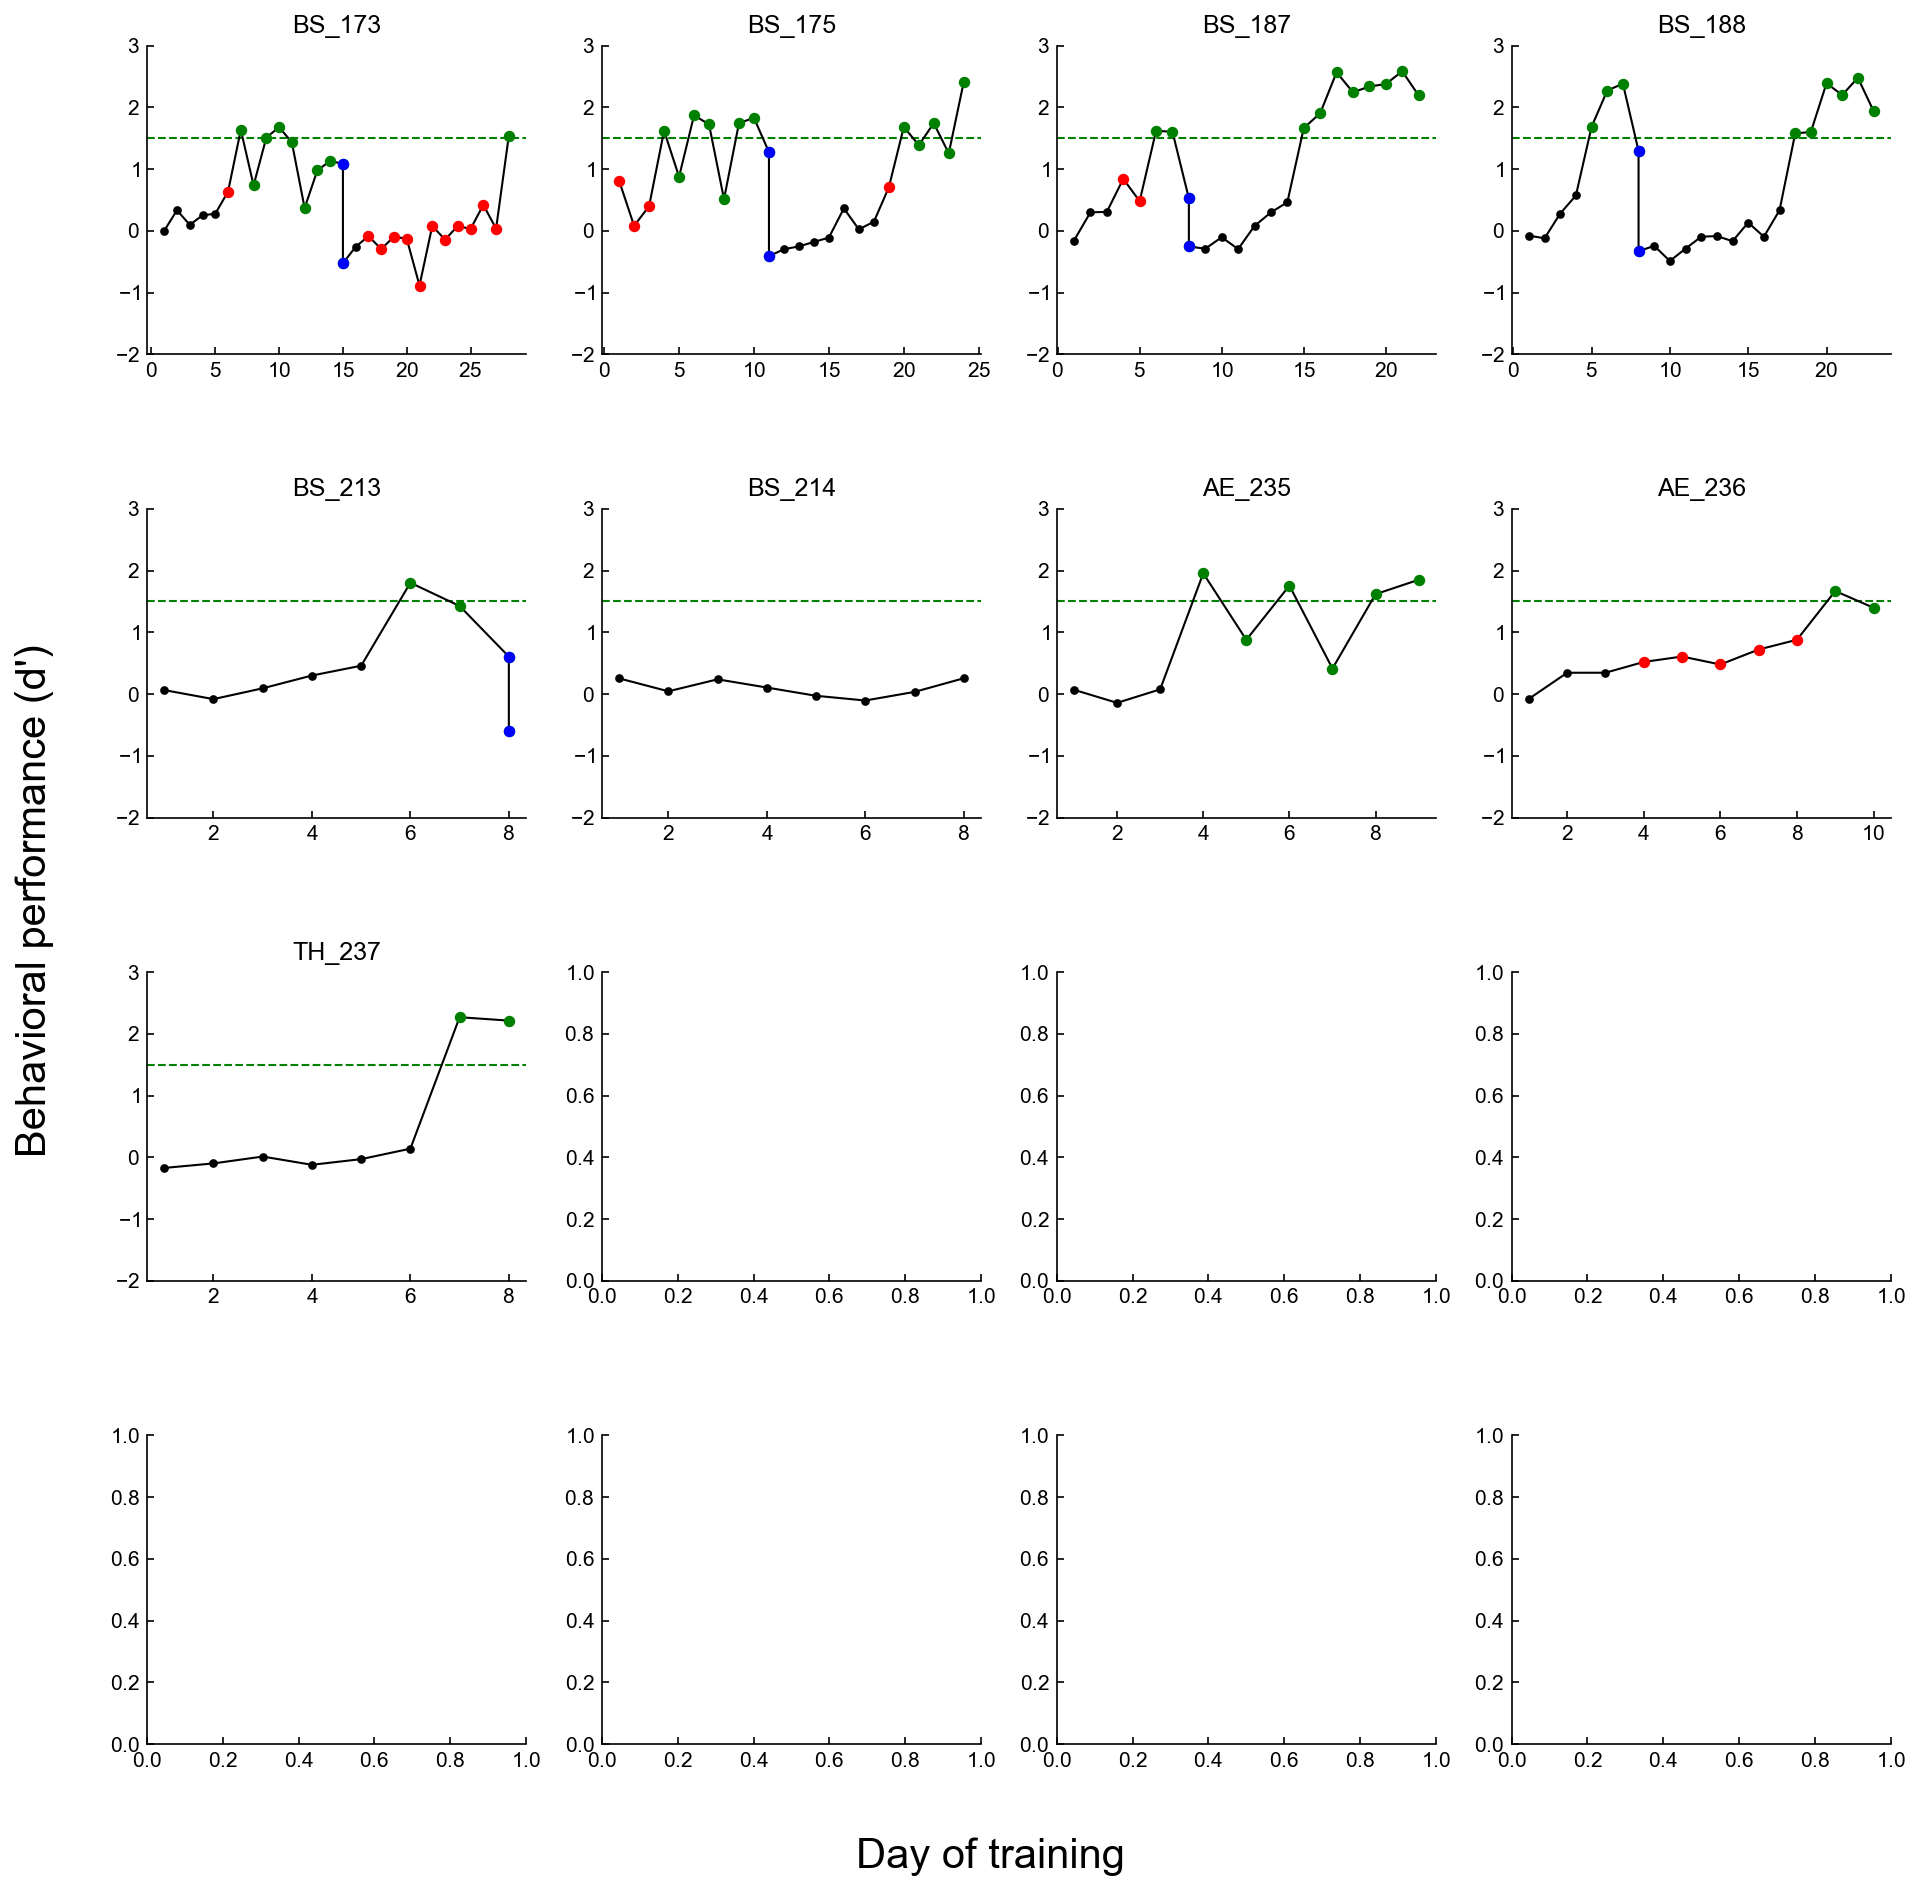

In [6]:
animalPhases = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

for animalidx,animal in enumerate(animals):
    print(animal)
    
    animalPhases[animal] = SimpleNamespace()
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    days = [k for k in animalBehaviors[animal].sessions]
    if np.isfinite(reversal):
        days.append(reversal)
    days = np.sort(days)
    
    pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
    expert_days = np.concatenate((pre_exp,post_exp))
    dp_list,pc_list = getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
            
    ############### Calculation of learning phases ###################
    
    pre_reversal_days_mask = np.less(days,reversal)
    post_reversal_days_mask = np.greater(days,reversal)
    
    pre_reversal_dp_list = dp_list[pre_reversal_days_mask]
    post_reversal_dp_list = dp_list[post_reversal_days_mask]
    if np.isfinite(reversal):
        pre_switch_dp = dp_list[reversal-1]
        post_switch_dp = dp_list[reversal]
    else:
        pre_switch_dp = dp_list[len(dp_list)-1]
        post_switch_dp = []
        
#     print(f"reversal at {reversal}")
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
    
    pre_rev_dp_concat = pre_reversal_dp_list#np.concatenate((pre_reversal_dp_list,pre_switch_dp))
    pre_rev_min = min(np.min(pre_reversal_dp_list),0)
    pre_rev_max = max(np.max(pre_reversal_dp_list),1.5)
    pre_reversal_dp_thresh = pre_rev_min + 0.3 * (pre_rev_max - pre_rev_min)
    post_rev_dp_concat = pre_reversal_dp_list#np.concatenate((post_reversal_dp_list,post_switch_dp))
#     print(f"post_rev dp list is {post_reversal_dp_list}")
    try:
        post_rev_min = min(np.min(post_reversal_dp_list),0)
        post_rev_max = max(np.max(post_reversal_dp_list),1.5)
        post_reversal_dp_thresh = post_rev_min + 0.3 * (post_rev_max - post_rev_min)
    except:
        post_rev_min = np.nan
        post_rev_max = np.nan
        post_reversal_dp_thresh = np.Inf

    pre_late_days_mask = np.greater_equal(pre_reversal_dp_list,pre_reversal_dp_thresh)
    post_late_days_mask = np.greater_equal(post_reversal_dp_list,post_reversal_dp_thresh)
    
    ############ Export final results to a list of days ############
    
    pre_reversal_days = np.where(pre_reversal_days_mask)[0] + 1
    post_reversal_days = np.where(post_reversal_days_mask)[0] # No +1 because double reversal day
    
    pre_expert_days = np.sort(pre_exp)
    post_expert_days = np.sort(post_exp)
    
    pre_late_days = np.where(pre_late_days_mask)[0] + 1
    post_late_days = np.where(post_late_days_mask)[0] + 1 + reversal # No +1 because adding reversal. +1 because double reversal
    
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
#     print(f"post_reversal list is {post_reversal_dp_list}")
#     print(f"pre_late days are {pre_late_days}")
#     print(f"post_late days are {post_late_days}")
    
    if len(pre_late_days)>0:
        last_day_late = reversal
        if not np.isfinite(reversal):
            last_day_late = np.max(days)
#             print(f"last day = {last_day_late}")
        pre_late_days = np.arange(np.min(pre_late_days),last_day_late)
    if len(post_late_days)>0:
        post_late_days = np.arange(np.min(post_late_days),max(days))
    pre_late_days = pre_late_days[np.logical_not(np.isin(pre_late_days,pre_expert_days))]
    post_late_days = post_late_days[np.logical_not(np.isin(post_late_days,post_expert_days))]
    
    pre_early_days = pre_reversal_days[np.logical_not(np.isin(pre_reversal_days,pre_late_days))]
    post_early_days = post_reversal_days[np.logical_not(np.isin(post_reversal_days,post_late_days))]
    pre_early_days = pre_early_days[np.logical_not(np.isin(pre_early_days,pre_expert_days))]
    post_early_days = post_early_days[np.logical_not(np.isin(post_early_days,post_expert_days))]
    
    if False:#animal in ['BS_72']:
        print(animal)
        print(f"reversal is {reversal}")
        print(f"dps are {dp_list}")

        print(f"Pre-reversal days mask: {pre_reversal_days_mask}")
        print(f"Post-reversal days mask: {post_reversal_days_mask}")

        print(f"Pre-reversal dps: {pre_reversal_dp_list}")
        print(f"Post-reversal dps: {post_reversal_dp_list}")

        print(f"Pre-reversal threshold: {pre_reversal_dp_thresh}")
        print(f"Post-reversal threshold: {post_reversal_dp_thresh}")

        print(f"Pre-reversal days: {pre_reversal_days}")
        print(f"Post-reversal days: {post_reversal_days}")

        print(f"Pre-early days: {pre_early_days}")
        print(f"Post-early days: {post_early_days}")

        print(f"Pre-late days: {pre_late_days}")
        print(f"Post-late days: {post_late_days}")

        print(f"Pre-expert days: {pre_expert_days}")
        print(f"Post-expert days: {post_expert_days}")
        
    animalPhases[animal].pre_early_days = pre_early_days
    animalPhases[animal].pre_late_days = pre_late_days
    animalPhases[animal].pre_expert_days = pre_expert_days
    if np.isfinite(reversal):
        animalPhases[animal].switch_days = [reversal]
    else:
        animalPhases[animal].switch_days = []
    animalPhases[animal].post_early_days = post_early_days
    animalPhases[animal].post_late_days = post_late_days
    animalPhases[animal].post_expert_days = post_expert_days
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,dp_list,color='k',lw=1)
        ax.scatter(days,dp_list,color='k',s=10,zorder=9)
        
        #Pre Late
        pre_late = np.isin(days,pre_late_days)
        ax.scatter(days[pre_late],dp_list[pre_late],color='r',s=20,zorder=10)
        #Post Late
        post_late = np.isin(days,post_late_days)
        ax.scatter(days[post_late],dp_list[post_late],color='r',s=20,zorder=10)
        
        #Pre Expert
        pre_expert = np.isin(days,pre_expert_days)
        ax.scatter(days[pre_expert],dp_list[pre_expert],color='g',s=20,zorder=10)
        #Post Expert
        post_expert = np.isin(days,post_expert_days)
        ax.scatter(days[post_expert],dp_list[post_expert],color='g',s=20,zorder=10)
        
        #Switch
        switch = np.equal(days,reversal)
        ax.scatter(days[switch],dp_list[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        #days_recorded = training_days_recorded[animal]
        #ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases Tuning.pdf'),transparent=False,facecolor="white")
    pass

In [23]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    if session in ['TH_217_4_tuning_AC.pickle']:
        continue
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task not in ['tuning nonreversal', 'tuning switch', 'tuning reversal']:
        continue
        
    if sessionfile.meta.animal == 'TH_217':
        continue
        
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
    for clust in sessionfile.clusters.good:
        if sessionfile.tuning.number_of_tones <= 0 or len(sessionfile.trim[clust].trimmed_tuning_trials) / len(np.unique(sessionfile.tuning.trial_freqs)) < 30:
            continue
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 533/533 [00:02<00:00, 182.80it/s]


In [24]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'pre expert'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in animalPhases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 957/957 [00:14<00:00, 65.05it/s] 

errors for: ['AE_231']


In [25]:
def CalculateBestFrequencies(sessionfile,clust):
    tones_to_consider = np.sort(np.unique(sessionfile.tuning.trial_freqs))
    tuning_FRs = np.full_like(tones_to_consider,np.nan)

    clust_spikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    for idx,tone in enumerate(tones_to_consider):

        #tone_trials = np.equal(sessionfile.tuning.trial_freqs,tone)
        #tone_trials = np.where(tone_trials)[0]
        #
        #this_tone_FRs = []
        #for trial in tone_trials:

            #trialstart = sessionfile.tuning.trial_starts[trial]

            #trial_spikes = len(ilep.getSpikeTimes(sessionfile,cachedtimes = clust_spikes,starttime = trialstart, endtime = trialstart+0.2*sessionfile.meta.fs))
            #trial_FR = trial_spikes / 0.2
            #this_tone_FRs.append(trial_FR)

        ##print(str(tone) + ': ' + str(this_tone_FRs))
        #tuning_FRs[idx] = np.mean(this_tone_FRs)
        
        tuning_FRs[idx] = sessionfile.tuning.tuning_responsiveness[clust][str(tone)].FRevoked
    
    maxidxs = np.argwhere(tuning_FRs >= np.max(tuning_FRs)*1)
    best_frequencies = tones_to_consider[maxidxs]
    best_frequencies = np.concatenate(best_frequencies)
    return best_frequencies

def plotTuningCurve(sessionfile,clust):
    tones_to_use = np.sort(np.unique(sessionfile.tuning.trial_freqs))
    tuning_FRs = np.full_like(tones_to_use,np.nan)
    tuning_FR_SEMs = np.full_like(tones_to_use,np.nan)

    clust_spikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    
    for idx,tone in enumerate(tones_to_use):

        tone_trials = np.equal(sessionfile.tuning.trial_freqs,tone)
        tone_trials = np.where(tone_trials)[0]

        this_tone_FRs = []
        for trial in tone_trials:

            trialstart = sessionfile.tuning.trial_starts[trial]

            trial_spikes = len(ilep.getSpikeTimes(sessionfile,cachedtimes = clust_spikes,starttime = trialstart, endtime = trialstart+0.2*sessionfile.meta.fs))
            trial_FR = trial_spikes / 0.2
            this_tone_FRs.append(trial_FR)

        #print(str(tone) + ': ' + str(this_tone_FRs))
        tuning_FRs[idx] = np.mean(this_tone_FRs)
        tuning_FR_SEMs[idx] = sem(this_tone_FRs)
        
    best_frequencies = CalculateBestFrequencies(sessionfile,clust)
    best_frequency_idxs = np.concatenate([np.argwhere(tones_to_use == f)[0] for f in best_frequencies])

    fig,ax = plt.subplots(figsize=(5,3))
    ax.plot(range(len(tuning_FRs)),tuning_FRs,color=GOOD_GREY,lw=1)
    ax.fill_between(range(len(tuning_FRs)),tuning_FRs-tuning_FR_SEMs,tuning_FRs+tuning_FR_SEMs,color=GOOD_GREY,alpha=0.125,lw=0,zorder=-10)
    ax.scatter(range(len(tuning_FRs)),tuning_FRs,color=GOOD_GREY,s=10)
    ax.scatter(best_frequency_idxs,tuning_FRs[best_frequency_idxs],color=GOOD_GREEN,s=50,zorder=10,label='best frequency')

    ax.set_xlabel('Tone Frequency (Hz)')
    ax.set_xticks(range(len(tuning_FRs)))
    ax.set_xticklabels(tones_to_use)
    ax.set_xlim([0,len(tuning_FRs)-1])

    ax.set_ylabel('Firing rate (spikes/s)')
    max_FR_value = np.max(tuning_FRs) * 1.1
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
    idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    limit = np.min(valid_limits)
    ax.set_ylim([0,limit])
    ax.set_yticks([0,limit/2,limit])
    ax.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    
    ax.legend(frameon=False,loc='upper right')
    
    return fig

In [26]:
pre_early_FRmod = []

pre_early_best_freqs = []
pre_early_weights = []

pre_late_best_freqs = []
pre_late_weights = []

pre_expert_best_freqs = []
pre_expert_weights = []

post_early_best_freqs = []
post_early_weights = []

post_late_best_freqs = []
post_late_weights = []

post_expert_best_freqs = []
post_expert_weights = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile = ilep.determineTuningCurveTones(sessionfile)
    
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if ilep.testInOrderTonePresentation(sessionfile):
        continue
        
    if len(np.unique(sessionfile.tuning.trial_freqs)) < 7:
        continue
    
    best_freqs = CalculateBestFrequencies(sessionfile,clust)
    weights = np.ones_like(best_freqs) / len(best_freqs)
    
    
    if EILphases[idx] == 'pre early':
        pre_early_FRmod.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        pre_early_best_freqs.append(best_freqs)
        pre_early_weights.append(weights)
    if EILphases[idx] == 'pre late':
        pre_late_best_freqs.append(best_freqs)
        pre_late_weights.append(weights)
    if EILphases[idx] == 'pre expert':
        pre_expert_best_freqs.append(best_freqs)
        pre_expert_weights.append(weights)
    if EILphases[idx] == 'post early':
        post_early_best_freqs.append(best_freqs)
        post_early_weights.append(weights)
    if EILphases[idx] == 'post late':
        post_late_best_freqs.append(best_freqs)
        post_late_weights.append(weights)
    if EILphases[idx] == 'post expert':
        post_expert_best_freqs.append(best_freqs)
        post_expert_weights.append(weights)


pre_early_best_freqs = np.concatenate(pre_early_best_freqs)
pre_early_weights = np.concatenate(pre_early_weights)
pre_late_best_freqs = np.concatenate(pre_late_best_freqs)
pre_late_weights = np.concatenate(pre_late_weights)
pre_expert_best_freqs = np.concatenate(pre_expert_best_freqs)
pre_expert_weights = np.concatenate(pre_expert_weights)
post_early_best_freqs = np.concatenate(post_early_best_freqs)
post_early_weights = np.concatenate(post_early_weights)
post_late_best_freqs = np.concatenate(post_late_best_freqs)
post_late_weights = np.concatenate(post_late_weights)
post_expert_best_freqs = np.concatenate(post_expert_best_freqs)
post_expert_weights = np.concatenate(post_expert_weights)

957it [00:16, 59.80it/s] 


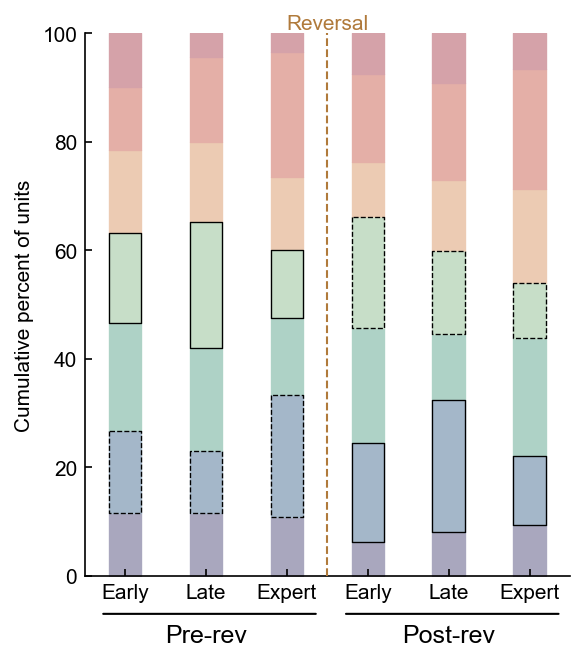

In [47]:
def plotBestFreqStack(ax,x,ylims,best_freqs,weights,width = 0.4,tntls=['-','-']):
    tones_250 = [4000,8000,16000,32000,64000]
    tones_350 = [4000,5648,8000,11260,16000,32000,64000]
    tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
    freqs_to_consider = tones_350
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = cmap(np.linspace(0,1,len(freqs_to_consider)))
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
    #colors_to_use = mpl.colors.Colormap('plasma',len(freqs_to_consider))
    
    total_weight = 0
    for tone in freqs_to_consider:
        this_tone_idx = np.equal(best_freqs,tone)
        total_weight += np.sum(weights[this_tone_idx])
        
    current_total = 0
    last_breakpoints = []
    breakpoints = [0]
    for idx,tone in enumerate(freqs_to_consider):
        this_tone_idx = np.equal(best_freqs,tone)
        this_tone_weight = np.sum(weights[this_tone_idx])
        if tone == 5648:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[0],edgecolor='k',zorder=10)#,hatch='XXXXXX'
        elif tone == 11260:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[1],edgecolor='k',zorder=10)
        else:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
        current_total += this_tone_weight
        breakpoints.append(current_total)
        
    return (breakpoints/total_weight)

def plotConnectingLines(breakpre,breakpost,X,width=0.125):
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    #colors_to_use = ['#b6888e','#80689D','#3d85c6','#78a5af','#78b0ac','#a4b49c','#4d4c55']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
        
        Y1 = [breakpre[idx],breakpost[idx]]
        Y2 = [breakpre[idx+1],breakpost[idx+1]]
        Xplot = [X[0]+width,X[1]-width]
        
        ax.fill_between(Xplot,Y1,Y2,color=colors_to_use[idx],alpha=0.125,lw=0,zorder=-30)

fig, ax = plt.subplots(figsize=(4,4.5))
#fig,ax = plt.subplots(figsize=(4,3))
breakspreEa = plotBestFreqStack(ax,0,[],pre_early_best_freqs,pre_early_weights,tntls=['--','-'])
breakspreLa = plotBestFreqStack(ax,1,[],pre_late_best_freqs,pre_late_weights,tntls=['--','-'])
#plotConnectingLines(breakspreEa,breakspreLa,[0,1])
breakspreEx = plotBestFreqStack(ax,2,[],pre_expert_best_freqs,pre_expert_weights,tntls=['--','-'])
#plotConnectingLines(breakspreLa,breakspreEx,[1,2])
breakspostEa = plotBestFreqStack(ax,3,[],post_early_best_freqs,post_early_weights,tntls=['-','--'])
#plotConnectingLines(breakspreEx,breakspostEa,[2,3])
breakspostLa = plotBestFreqStack(ax,4,[],post_late_best_freqs,post_late_weights,tntls=['-','--'])
#plotConnectingLines(breakspostEa,breakspostLa,[3,4])
breakspostEx = plotBestFreqStack(ax,5,[],post_expert_best_freqs,post_expert_weights,tntls=['-','--'])
#plotConnectingLines(breakspostLa,breakspostEx,[4,5])

tones_250 = [4000,8000,16000,32000,64000]
tones_350 = [4000,5648,8000,11260,16000,32000,64000]
tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
tones_to_use = tones_350
cmap = mpl.cm.get_cmap('Set2')
colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
for idx,tone in enumerate(tones_to_use):
    ax.fill_between([],[],[],color = colors_to_use[idx],label=str(np.floor(tone/100)/10),lw=0.65)
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='-',label='target')
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='--',label='non-target')

labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
#ax.set_xlim([-0.2,5.2])
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('Cumulative percent of units')

#ax.legend(frameon=False,loc=[1,0.35])

# ax.text(0,1.01,int(np.sum(pre_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(1,1.01,int(np.sum(pre_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(2,1.01,int(np.sum(pre_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(3,1.01,int(np.sum(post_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(4,1.01,int(np.sum(post_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
# ax.text(5,1.01,int(np.sum(post_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.annotate('', xy=(-0.02, -0.1), xycoords='axes fraction', xytext=(0.48, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('', xy=(0.535, -0.1), xycoords='axes fraction', xytext=(1.035, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('Early', xy=(0.1, -0.18), xycoords='axes fraction', xytext=(0.1, -0.18),color='black',fontsize=12)
#ax.annotate('Post-rev', xy=(0.64, -0.18), xycoords='axes fraction', xytext=(0.64, -0.18),color='black',fontsize=12)
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.985, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()


#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join ('C:\\\\Users\\insan\\Desktop\\Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Automated best frequency over learning.pdf'),transparent=False,facecolor="white")

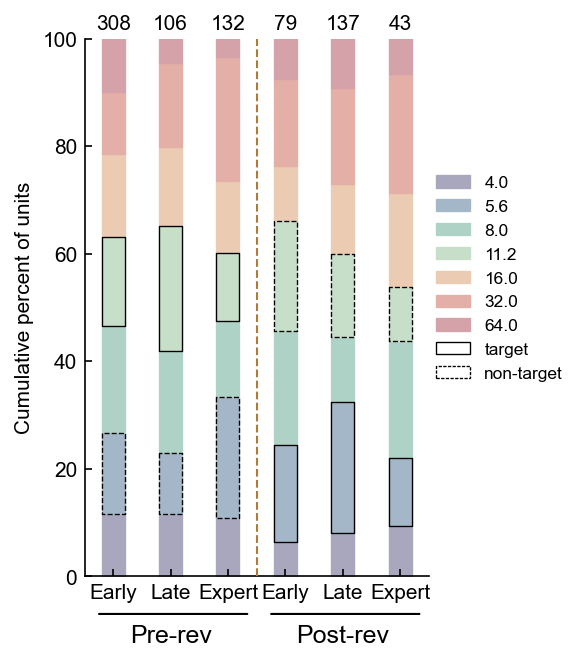

In [45]:
def plotBestFreqStack(ax,x,ylims,best_freqs,weights,width = 0.4,tntls=['-','-']):
    tones_250 = [4000,8000,16000,32000,64000]
    tones_350 = [4000,5648,8000,11260,16000,32000,64000]
    tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
    freqs_to_consider = tones_350
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = cmap(np.linspace(0,1,len(freqs_to_consider)))
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
    #colors_to_use = mpl.colors.Colormap('plasma',len(freqs_to_consider))
    
    total_weight = 0
    for tone in freqs_to_consider:
        this_tone_idx = np.equal(best_freqs,tone)
        total_weight += np.sum(weights[this_tone_idx])
        
    current_total = 0
    last_breakpoints = []
    breakpoints = [0]
    for idx,tone in enumerate(freqs_to_consider):
        this_tone_idx = np.equal(best_freqs,tone)
        this_tone_weight = np.sum(weights[this_tone_idx])
        if tone == 5648:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[0],edgecolor='k',zorder=10)#,hatch='XXXXXX'
        elif tone == 11260:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65,linestyle=tntls[1],edgecolor='k',zorder=10)
        else:
            ax.fill_between([x-width/2,x+width/2],[current_total/total_weight]*2,[(current_total+this_tone_weight)/total_weight]*2,color=colors_to_use[idx],lw=0.65)
        current_total += this_tone_weight
        breakpoints.append(current_total)
        
    return (breakpoints/total_weight)

def plotConnectingLines(breakpre,breakpost,X,width=0.125):
    cmap = mpl.cm.get_cmap('Set2')
    #colors_to_use = ['#80689D','#4D4C55','#78B0AC','#a4b49c','#76a5af','#3d85c6','#B6888E']
    #colors_to_use = ['#b6888e','#80689D','#3d85c6','#78a5af','#78b0ac','#a4b49c','#4d4c55']
    colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
    for idx,color in enumerate(colors_to_use):
        r,g,b = mpl.colors.to_rgb(color)
        h,l,s = colorsys.rgb_to_hls(r,g,b)
        color=np.concatenate([colorsys.hls_to_rgb(h,(1-(1-l)*1)*1,s*1),[1]])
        colors_to_use[idx] = color
        
        Y1 = [breakpre[idx],breakpost[idx]]
        Y2 = [breakpre[idx+1],breakpost[idx+1]]
        Xplot = [X[0]+width,X[1]-width]
        
        ax.fill_between(Xplot,Y1,Y2,color=colors_to_use[idx],alpha=0.125,lw=0,zorder=-30)

fig, ax = plt.subplots(figsize=(4,4.5))
#fig,ax = plt.subplots(figsize=(4,3))
breakspreEa = plotBestFreqStack(ax,0,[],pre_early_best_freqs,pre_early_weights,tntls=['--','-'])
breakspreLa = plotBestFreqStack(ax,1,[],pre_late_best_freqs,pre_late_weights,tntls=['--','-'])
#plotConnectingLines(breakspreEa,breakspreLa,[0,1])
breakspreEx = plotBestFreqStack(ax,2,[],pre_expert_best_freqs,pre_expert_weights,tntls=['--','-'])
#plotConnectingLines(breakspreLa,breakspreEx,[1,2])
breakspostEa = plotBestFreqStack(ax,3,[],post_early_best_freqs,post_early_weights,tntls=['-','--'])
#plotConnectingLines(breakspreEx,breakspostEa,[2,3])
breakspostLa = plotBestFreqStack(ax,4,[],post_late_best_freqs,post_late_weights,tntls=['-','--'])
#plotConnectingLines(breakspostEa,breakspostLa,[3,4])
breakspostEx = plotBestFreqStack(ax,5,[],post_expert_best_freqs,post_expert_weights,tntls=['-','--'])
#plotConnectingLines(breakspostLa,breakspostEx,[4,5])

tones_250 = [4000,8000,16000,32000,64000]
tones_350 = [4000,5648,8000,11260,16000,32000,64000]
tones_450 = [4000,5648,8000,11260,16000,22627,32000,45255,64000]
tones_to_use = tones_350
cmap = mpl.cm.get_cmap('Set2')
colors_to_use = ['#A9A7BE','#A4B7C9','#AED2C6','#C7DEC8','#ECCBB3','#E4AFA7','#D5A2A9']
for idx,tone in enumerate(tones_to_use):
    ax.fill_between([],[],[],color = colors_to_use[idx],label=str(np.floor(tone/100)/10),lw=0.65)
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='-',label='target')
ax.fill_between([],[],[],color = 'white', ec = 'k', lw=0.65, linestyle='--',label='non-target')

labels = ['Early','Late','Expert','Early','Late','Expert']
#labels = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']
#ax.set_xlim([-0.2,5.2])
ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
ax.set_ylabel('Cumulative percent of units')

ax.legend(frameon=False,loc=[1,0.35])

ax.text(0,1.01,int(np.sum(pre_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(1,1.01,int(np.sum(pre_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(2,1.01,int(np.sum(pre_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(3,1.01,int(np.sum(post_early_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(4,1.01,int(np.sum(post_late_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)
ax.text(5,1.01,int(np.sum(post_expert_weights)),horizontalalignment='center',verticalalignment='bottom',fontsize=10)

#ax.annotate('', xy=(-0.02, -0.1), xycoords='axes fraction', xytext=(0.48, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('', xy=(0.535, -0.1), xycoords='axes fraction', xytext=(1.035, -0.1),arrowprops=dict(arrowstyle='-', color='black'))
#ax.annotate('Early', xy=(0.1, -0.18), xycoords='axes fraction', xytext=(0.1, -0.18),color='black',fontsize=12)
#ax.annotate('Post-rev', xy=(0.64, -0.18), xycoords='axes fraction', xytext=(0.64, -0.18),color='black',fontsize=12)
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.13304656298982956/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.13304656298982956/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.485, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.985, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.tight_layout()


#fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
#fig.savefig(os.path.join ('C:\\\\Users\\insan\\Desktop\\Figures','Best frequency over learning with TH_217.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Automated best frequency over learning LEGEND.pdf'),transparent=False,facecolor="white")